## RATINGS PREDICTION`

We have a client who has a website where people write different reviews for technical products.
Now they are adding a new feature to their website i.e. The reviewer will have to add stars(rating)
as well with the review. The rating is out 5 stars and it only has 5 options available 1 star, 2 stars,
3 stars, 4 stars, 5 stars. Now they want to predict ratings for the reviews which were written in the
past and they don’t have a rating. So, we have to build an application which can predict the rating
by seeing the review.

## Data Collection Phase

## Web Scraping

In [1]:
#i have scapred more than 20,000 rows of data for different products

In [4]:
#For each rating 1,2,3,4,5 will scraped equal ratings to balance the dataset

## Importing all the required libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize import word_tokenize,regexp_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import string
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import gensim
from gensim import corpora
from pprint import pprint
from gensim.utils import simple_preprocess
import os


## Loading the dataset:

In [6]:
#dataset 
df_ratings = pd.read_csv('final_rating.csv',encoding='latin-1')
df_ratings.head()

Unnamed: 0  Unnamed: 0.1  Rating  \
0          49            49       1   
1          51            51       1   
2          52            52       1   
3          71            71       1   
4          72            72       1   

                                         Full_review  
0  waste product simply bass sound but beating al...  
1                     Very bad sound. Don't buy it .  
2     bass is not working it's like speaker ð­ð­  
3  Very bad, from the first day onwards four spea...  
4  Bass and sound quality are so bad. Don't buy i...

In [7]:
#removing unnecessary columns
df_ratings.drop(["Unnamed: 0",'Unnamed: 0.1'],axis = 1,inplace= True)

In [8]:
df_ratings.head()

Rating                                        Full_review
0       1  waste product simply bass sound but beating al...
1       1                     Very bad sound. Don't buy it .
2       1     bass is not working it's like speaker ð­ð­
3       1  Very bad, from the first day onwards four spea...
4       1  Bass and sound quality are so bad. Don't buy i...

## EDA (Exploratory Data Analysis)

In [9]:
#i have scapred 4 columns
#1. Rating
#2. Full_Review

In [10]:
#lets check for null values in this datset
df_ratings.isnull().sum()

Rating         0
Full_review    0
dtype: int64

In [11]:
#since it only one row, lets drop it
df_ratings.dropna(inplace=True)

In [12]:
#lets check for null values in this datset
df_ratings.isnull().sum()

Rating         0
Full_review    0
dtype: int64

In [13]:
#now there are no null values

In [14]:
#we have 24870 rows for review
#"GOOD" is the top review
df_ratings.Full_review.describe()

count                                                 24870
unique                                                12713
top       Not good to talk .you can use this earphone to...
freq                                                   1826
Name: Full_review, dtype: object

In [15]:
#lets check for class imbalance problem
df_ratings.Rating.value_counts()

5    4974
4    4974
3    4974
2    4974
1    4974
Name: Rating, dtype: int64

In [16]:
#our data set balanced with almost 4100 ratings for evry review

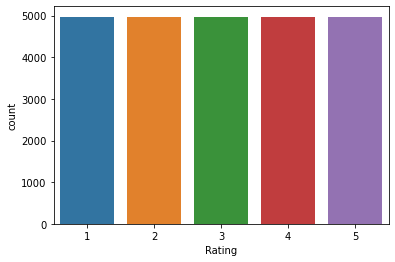

In [17]:
#count plot
sns.countplot(df_ratings.Rating)
plt.show()

In [18]:
#we can see that our data is very much balanced for each review with 4000 reviews for every rating

## Data Preprocessing

In [19]:
#adding the words to the stopwords which are not necessary in out text data
stopset =set(stopwords.words('english')+['i','u','ur','4','2','im','dont','doin','ure'])
len(stopset)

187

In [20]:
#adding the punctuation to the punctuation which are not necessary in out text data
punc = set(string.punctuation + '‘’,:”][]``'+'``')
print(punc)
print(len(punc))

{'*', ')', ';', '&', '.', '/', '=', '<', '(', '!', ':', '|', '-', '+', '}', '>', '#', '?', '[', '`', '‘', "'", ']', '^', '{', '~', ',', '_', '\\', '”', '%', '"', '’', '@', '$'}
35


In [21]:
df_ratings.Full_review.head()

0    waste product simply bass sound but beating al...
1                       Very bad sound. Don't buy it .
2       bass is not working it's like speaker ð­ð­
3    Very bad, from the first day onwards four spea...
4    Bass and sound quality are so bad. Don't buy i...
Name: Full_review, dtype: object

In [22]:
#lets create a column called lenght
df_ratings['Concat_Length'] = df_ratings.Full_review.str.len()

In [23]:
df_ratings.head()

Rating                                        Full_review  Concat_Length
0       1  waste product simply bass sound but beating al...             70
1       1                     Very bad sound. Don't buy it .             30
2       1     bass is not working it's like speaker ð­ð­             46
3       1  Very bad, from the first day onwards four spea...            361
4       1  Bass and sound quality are so bad. Don't buy i...             87

In [24]:
#filtering all the non alphabetic words
#df_ratings['Clened Review'] = df_ratings.Final_Review.filter(regex='[^a-z]+')

In [25]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [26]:
def cleaning(text):
    text = text.lower()
    
    #Removing the html strips
    text = strip_html(text)
    
    #removing stopwords and punctuations
    text = " ".join([word for word in word_tokenize(text) if word not in stopset if word not in punc])
    
    #alpha numeric words
    text=re.sub('\w*\d+\w*','',text)
    
    text=re.sub('\[.*?\]','',text)
    
    #ectra punctiations
    text=re.sub('[''"",,,]','',text)
    
    #removing \n
    text=re.sub('\n','',text)
    
    #replacing numbers
    text = re.sub(r'\[[0-9]*\]', ' ',text)
    
    #replacing single characters
    text = re.sub(r'\s[A-Za-z0-9]\s','',text)
    
    #replacing single digits
    text = re.sub(r'\d+',' ',text)
    
    #replacing other charcters with space
    text = re.sub(r'[^a-zA-z0-9\s]+',' ',text)
    
    #replacing more than one white spaces
    text = re.sub(r'\s+',' ',text)
    
    return text

In [27]:
cleaned = lambda x : cleaning(x)

In [28]:
df_ratings['Review_Final'] = df_ratings.Full_review.apply(cleaned)

In [29]:
df_ratings.head()

Rating                                        Full_review  Concat_Length  \
0       1  waste product simply bass sound but beating al...             70   
1       1                     Very bad sound. Don't buy it .             30   
2       1     bass is not working it's like speaker ð­ð­             46   
3       1  Very bad, from the first day onwards four spea...            361   
4       1  Bass and sound quality are so bad. Don't buy i...             87   

                                        Review_Final  
0  waste product simply bass sound beating also w...  
1                                  bad sound n t buy  
2                       bass working s like speaker   
3  bad first day onwards four speakers voice clar...  
4    bass sound quality bad n t buy buy today crying

In [30]:
df_ratings['Length_Final'] = df_ratings.Review_Final.str.len()

In [31]:
df_ratings.head()

Rating                                        Full_review  Concat_Length  \
0       1  waste product simply bass sound but beating al...             70   
1       1                     Very bad sound. Don't buy it .             30   
2       1     bass is not working it's like speaker ð­ð­             46   
3       1  Very bad, from the first day onwards four spea...            361   
4       1  Bass and sound quality are so bad. Don't buy i...             87   

                                        Review_Final  Length_Final  
0  waste product simply bass sound beating also w...            63  
1                                  bad sound n t buy            17  
2                       bass working s like speaker             28  
3  bad first day onwards four speakers voice clar...           222  
4    bass sound quality bad n t buy buy today crying            47

## Lemmatization

In [32]:
from nltk.stem import WordNetLemmatizer,PorterStemmer

In [33]:
lemma = WordNetLemmatizer()
porter = PorterStemmer()

In [34]:
#calling lematization using funcation
def lemmatize(text):
    text = text.lower()
    text = " ".join([lemma.lemmatize(word,pos='v') for word in word_tokenize(text) if word not in punc])
    return text

In [35]:
#cleaning text data using lematization
df_ratings['cleaned_review'] = df_ratings.Review_Final.apply(lambda x : lemmatize(x))

In [36]:
df_ratings.head()

Rating                                        Full_review  Concat_Length  \
0       1  waste product simply bass sound but beating al...             70   
1       1                     Very bad sound. Don't buy it .             30   
2       1     bass is not working it's like speaker ð­ð­             46   
3       1  Very bad, from the first day onwards four spea...            361   
4       1  Bass and sound quality are so bad. Don't buy i...             87   

                                        Review_Final  Length_Final  \
0  waste product simply bass sound beating also w...            63   
1                                  bad sound n t buy            17   
2                       bass working s like speaker             28   
3  bad first day onwards four speakers voice clar...           222   
4    bass sound quality bad n t buy buy today crying            47   

                                      cleaned_review  
0  waste product simply bass sound beat also wast...  
1                                  bad sound n t buy  
2                           bass work s like speaker  
3  bad first day onwards four speakers voice clar...  
4       bass sound quality bad n t buy buy today cry

In [37]:
df_ratings.cleaned_review =df_ratings.cleaned_review.str.replace(r'\s+\w\s+',' ')
df_ratings.cleaned_review =df_ratings.cleaned_review.str.replace(r'\s+',' ')

In [38]:
df_ratings.dtypes

Rating             int64
Full_review       object
Concat_Length      int64
Review_Final      object
Length_Final       int64
cleaned_review    object
dtype: object

In [39]:
#lets covert our rating column to object datatype

df_ratings['Rating'] = df_ratings.Rating.astype('int')

In [40]:
#now our rating column is object datatype
df_ratings.dtypes

Rating             int32
Full_review       object
Concat_Length      int64
Review_Final      object
Length_Final       int64
cleaned_review    object
dtype: object

## Length of Words Before Cleaning based on Ratings

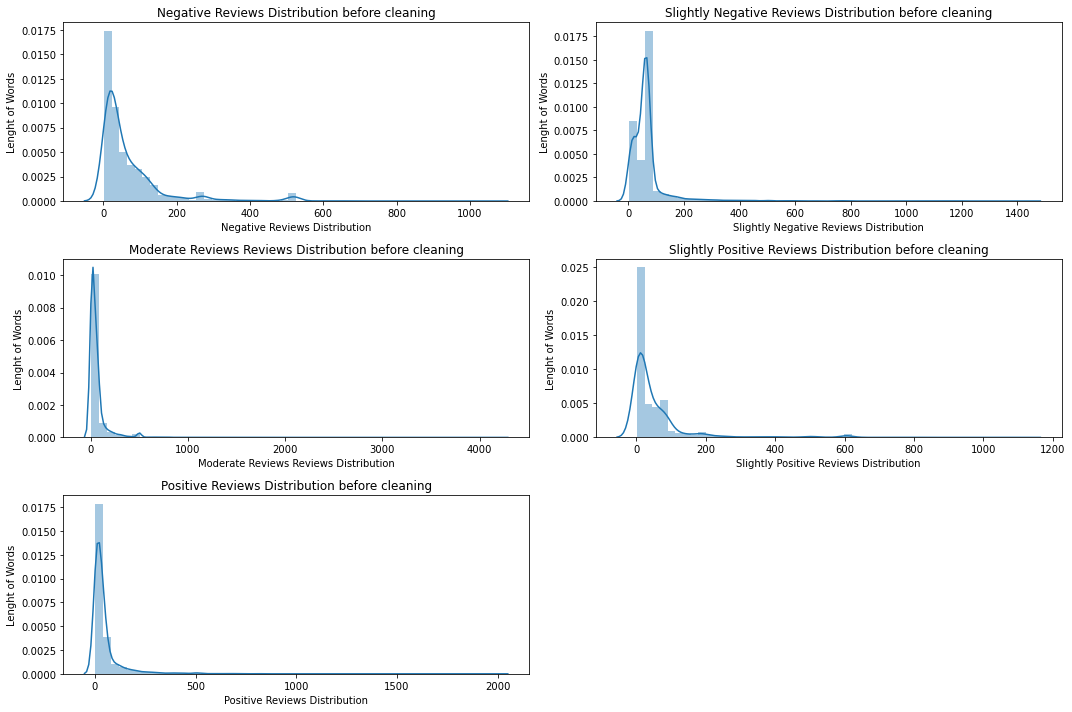

In [41]:
#Reviews distibution before cleaning
labels = ['Negative Reviews Distribution','Slightly Negative Reviews Distribution','Moderate Reviews Reviews Distribution',
          'Slightly Positive Reviews Distribution','Positive Reviews Distribution']
plt.figure(figsize= (15,10))
for i in range(len(labels)):
    plt.subplot(3,2,i+1)
    sns.distplot(df_ratings[df_ratings['Rating']==i+1]['Concat_Length'])
    plt.title(labels[i]+" before cleaning")
    plt.xlabel(labels[i])
    plt.ylabel('Lenght of Words')
    plt.tight_layout()

## Length of Words After Cleaning based on Ratings

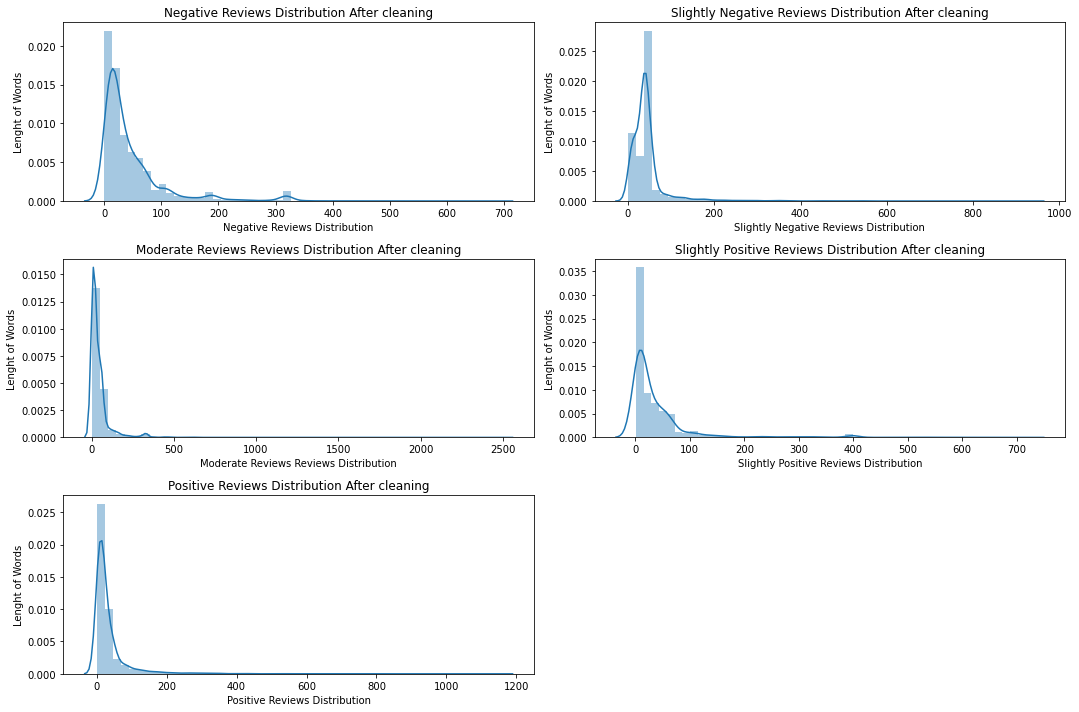

In [42]:
#Reviews distibution before cleaning
labels = ['Negative Reviews Distribution','Slightly Negative Reviews Distribution','Moderate Reviews Reviews Distribution',
          'Slightly Positive Reviews Distribution','Positive Reviews Distribution']
plt.figure(figsize= (15,10))
for i in range(len(labels)):
    plt.subplot(3,2,i+1)
    sns.distplot(df_ratings[df_ratings['Rating']==i+1]['Length_Final'])
    plt.title(labels[i]+" After cleaning")
    plt.xlabel(labels[i])
    plt.ylabel('Lenght of Words')
    plt.tight_layout()

In [43]:
#we can see the difference the lenght of each ratings.

## Word Cloud of Positive Reviews

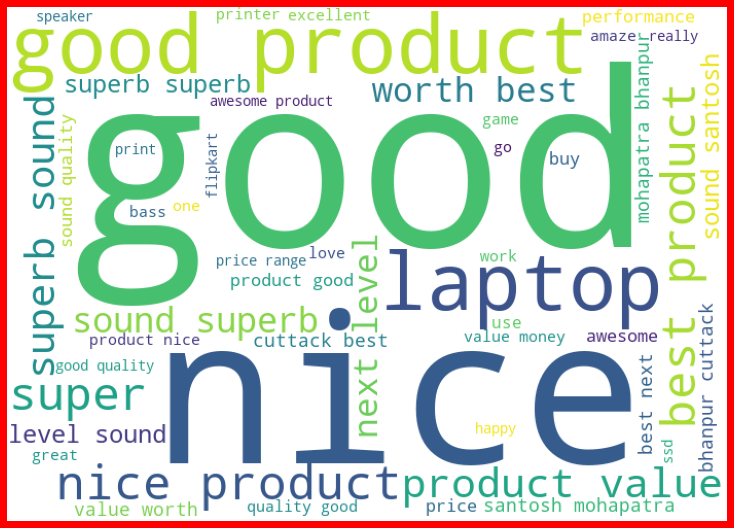

In [44]:
#wordcloud of positive reviews
from wordcloud import WordCloud

positive_reviews = df_ratings['cleaned_review'][df_ratings['Rating'] == 5]
positive_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(positive_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(positive_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Word Cloud of Negative Reviews

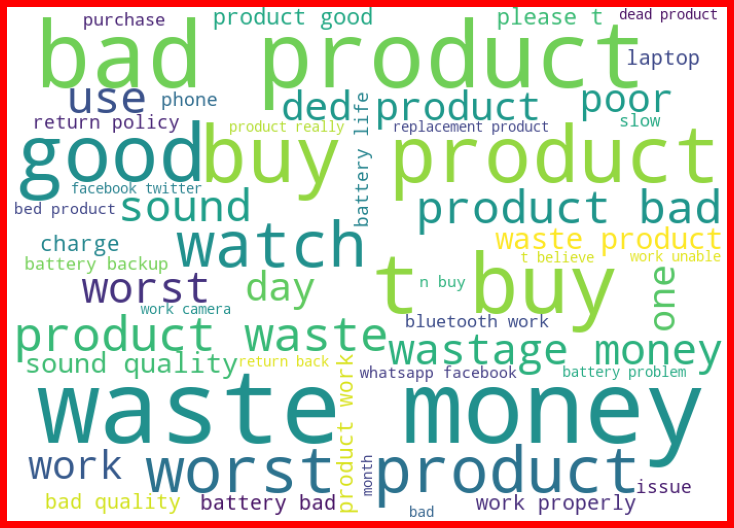

In [45]:
#wordcloud of Negative reviews
from wordcloud import WordCloud
Negative_reviews = df_ratings['cleaned_review'][df_ratings['Rating'] == 1]
Negative_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(Negative_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(Negative_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Word Cloud of Moderate Reviews

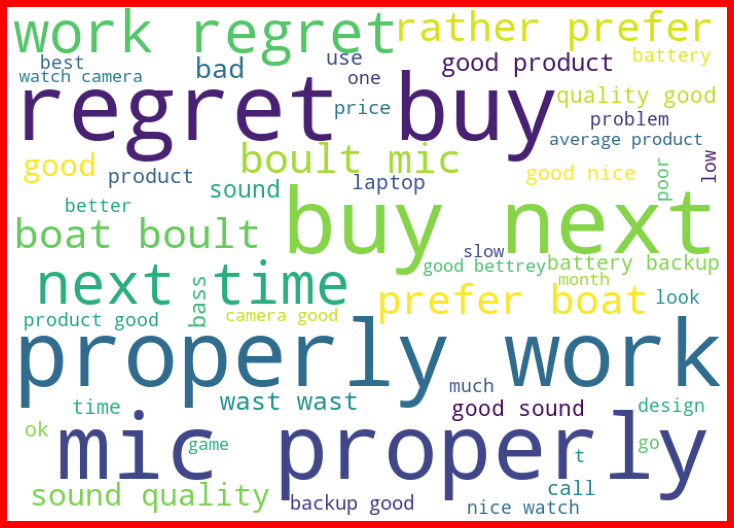

In [46]:
#wordcloud of Moderate_reviews
from wordcloud import WordCloud
Moderate_reviews = df_ratings['cleaned_review'][df_ratings['Rating'] == 3]
Moderate_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(Moderate_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(Moderate_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

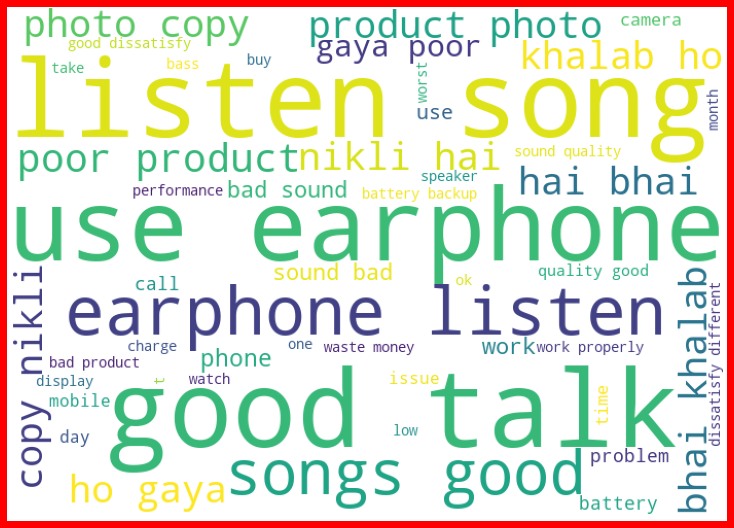

In [47]:
#wordcloud of 3rd rating reviews
from wordcloud import WordCloud
Moderate_reviews = df_ratings['cleaned_review'][df_ratings['Rating'] == 2]
Moderate_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(Moderate_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(Moderate_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

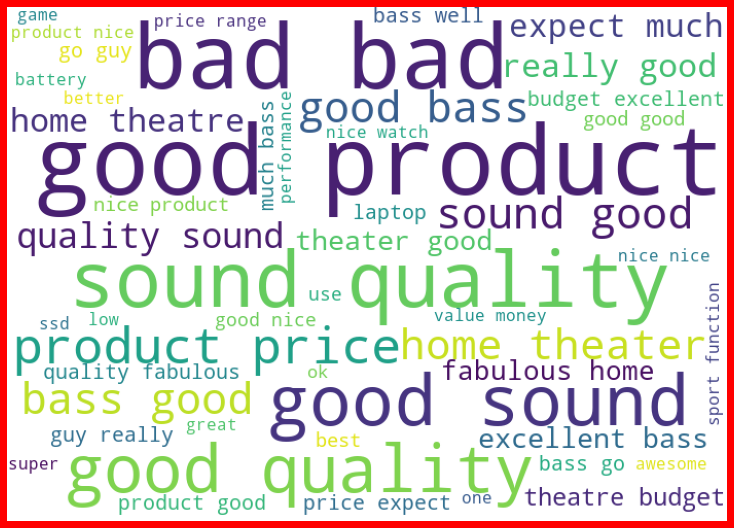

In [48]:
#wordcloud of 4th rating reviews
from wordcloud import WordCloud
Moderate_reviews = df_ratings['cleaned_review'][df_ratings['Rating'] == 4]
Moderate_reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(Moderate_reviews))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(Moderate_reviews_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Model Building

In [49]:
#importing required libraries to build model
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
tf_vec =TfidfVectorizer()
naive = MultinomialNB()
label = LabelEncoder()
lr = LogisticRegression()

In [50]:
#count vectorizer
count_vec = CountVectorizer()
count_vec_features = count_vec.fit_transform(df_ratings.cleaned_review)

In [51]:
#tfidf
tf_vec =TfidfVectorizer()
tf_features = tf_vec.fit_transform(df_ratings.cleaned_review)

In [52]:
#shape of array
count_vec_features.shape

(24870, 7561)

In [53]:
#shape of array
tf_features.shape

(24870, 7561)

## Naive Bayes Model with Count Vectorizer

In [54]:
#naive bayes model with count vectorizer features
X= count_vec_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y)

naive.fit(x_train,y_train)

y_pred = naive.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6180443872627854

               precision    recall  f1-score   support

           1       0.63      0.75      0.69      1244
           2       0.89      0.58      0.70      1273
           3       0.66      0.54      0.59      1202
           4       0.44      0.52      0.47      1219
           5       0.60      0.70      0.65      1280

    accuracy                           0.62      6218
   macro avg       0.64      0.62      0.62      6218
weighted avg       0.65      0.62      0.62      6218



## Naive Bayes Model with TF-IDF Vectorizer

In [55]:
#naive bayes model with Tfidf features
X= tf_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

naive.fit(x_train,y_train)

y_pred = naive.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6103248633000965

               precision    recall  f1-score   support

           1       0.59      0.74      0.66      1257
           2       0.89      0.55      0.68      1243
           3       0.66      0.52      0.58      1246
           4       0.45      0.59      0.51      1243
           5       0.62      0.65      0.63      1229

    accuracy                           0.61      6218
   macro avg       0.64      0.61      0.61      6218
weighted avg       0.64      0.61      0.61      6218



## Random Forest Model with Count Vectorizer

In [56]:
#Random Forest model with Count Vectorizer
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()


X= count_vec_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6381473142489547

               precision    recall  f1-score   support

           1       0.65      0.73      0.69      1257
           2       0.81      0.64      0.72      1243
           3       0.70      0.52      0.60      1246
           4       0.51      0.62      0.56      1243
           5       0.61      0.67      0.63      1229

    accuracy                           0.64      6218
   macro avg       0.65      0.64      0.64      6218
weighted avg       0.65      0.64      0.64      6218



## Random Forest Model with TF-IDF

In [57]:
#Random Forest model with TF-IDF
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

X= tf_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6481183660340946

               precision    recall  f1-score   support

           1       0.66      0.75      0.70      1257
           2       0.83      0.65      0.73      1243
           3       0.70      0.52      0.60      1246
           4       0.53      0.63      0.57      1243
           5       0.60      0.69      0.64      1229

    accuracy                           0.65      6218
   macro avg       0.66      0.65      0.65      6218
weighted avg       0.66      0.65      0.65      6218



## SVC Model with Count Vectorizer

In [58]:
#SVC model with Count Vectorizer
from sklearn.svm import SVC

svc =  SVC()

X= count_vec_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6471534255387584

               precision    recall  f1-score   support

           1       0.63      0.77      0.69      1257
           2       0.92      0.62      0.74      1243
           3       0.66      0.56      0.60      1246
           4       0.51      0.65      0.57      1243
           5       0.65      0.64      0.64      1229

    accuracy                           0.65      6218
   macro avg       0.67      0.65      0.65      6218
weighted avg       0.67      0.65      0.65      6218



## SVC Model with TF-IDF Vectorizer

In [59]:
#SVC model with TF-IDF
X= tf_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6617883563846896

               precision    recall  f1-score   support

           1       0.65      0.79      0.71      1257
           2       0.88      0.64      0.74      1243
           3       0.69      0.55      0.61      1246
           4       0.55      0.62      0.58      1243
           5       0.62      0.71      0.66      1229

    accuracy                           0.66      6218
   macro avg       0.68      0.66      0.66      6218
weighted avg       0.68      0.66      0.66      6218



## Hyper Parameter Tuning for Random Forest with TF-IDF

In [60]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#lets create the parameter list to pass in Randomised serach cv
parameters = {'n_estimators':[100,200,300,400,500],'criterion' : ['gini','entropy']}

In [61]:
#using grid search CV

X= tf_features
Y = df_ratings.Rating
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

gsv = GridSearchCV(estimator= rf , param_grid=parameters,cv =5)
gsv.fit(x_train,y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [62]:
#checking best parameters
gsv.best_params_

{'criterion': 'gini', 'n_estimators': 400}

In [63]:
gsv.best_score_

0.6564981033482963

## Creating the ranfom forest model using the attributes obtained form Randomized search Cv

In [72]:
rf_final  = RandomForestClassifier(criterion='gini',n_estimators = 400)

X= tf_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

rf_final.fit(x_train,y_train)

y_pred = rf_final.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6476358957864266

               precision    recall  f1-score   support

           1       0.65      0.75      0.69      1257
           2       0.83      0.65      0.73      1243
           3       0.71      0.53      0.61      1246
           4       0.53      0.61      0.57      1243
           5       0.60      0.70      0.64      1229

    accuracy                           0.65      6218
   macro avg       0.66      0.65      0.65      6218
weighted avg       0.66      0.65      0.65      6218



In [73]:
from sklearn.metrics import confusion_matrix
print("confusion matrix = >\n ",confusion_matrix(y_test,rf_final.predict(x_test)))

confusion matrix = >
  [[941  83  72 110  51]
 [255 802  72  65  49]
 [154  57 665 217 153]
 [ 60  12  84 759 328]
 [ 42  10  44 273 860]]


## Cross validation Score Random Forest

In [74]:
from sklearn.model_selection import cross_val_score


cv_score = cross_val_score(rf_final,x_train,y_train,cv =5)
print("cross val score :",  cv_score.mean())

cross val score : 0.6558014548062283


## Hyper Parameter Tuning for SVC with TF-IDF

In [67]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
#lets create the parameter list to pass in Randomised serach cv

parameters = {'kernel':['linear','poly','rbf']}

gsv = GridSearchCV(estimator= svc , param_grid=parameters,cv =5)
gsv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'kernel': ['linear', 'poly', 'rbf']})

In [68]:
#checking best parameters
gsv.best_params_

{'kernel': 'rbf'}

## Creating the SVC model using the attributes obtained form Randomized search Cv

In [69]:
svc_final  = SVC(kernel='rbf')

X= tf_features
Y = df_ratings.Rating

x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=42)

svc_final.fit(x_train,y_train)

y_pred = svc_final.predict(x_test)

print("Final Score = > ",accuracy_score(y_test,y_pred))
print("\n",classification_report(y_test,y_pred))

Final Score = >  0.6617883563846896

               precision    recall  f1-score   support

           1       0.65      0.79      0.71      1257
           2       0.88      0.64      0.74      1243
           3       0.69      0.55      0.61      1246
           4       0.55      0.62      0.58      1243
           5       0.62      0.71      0.66      1229

    accuracy                           0.66      6218
   macro avg       0.68      0.66      0.66      6218
weighted avg       0.68      0.66      0.66      6218



In [79]:
#compare to both random forest and svm, SVM has more accuracy of 66.17 percent. 

## Saving the model:

In [75]:
#serialization using joblib
import joblib
joblib.dump(svc_final,'Rating_prediction.obj')

['Rating_prediction.obj']

In [76]:
Rating_prediction = joblib.load('Rating_prediction.obj')

In [77]:
accuracy_score(Rating_prediction.predict(x_test),y_test)

0.6617883563846896